In [3]:
import argparse
import os
import warnings
import yaml
import sys
sys.path.append('/home/pasti/PycharmProjects/Robot_CLOD/')
import simclr.models
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.accelerators import find_usable_cuda_devices
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from nanodet.data.collate import naive_collate
from nanodet.data.dataset import build_dataset
from nanodet.evaluator import build_evaluator
from nanodet.trainer.task import TrainingTask
from nanodet.trainer.latent_dist_task import LatentDistTrainingTask
from torchvision.transforms import ToTensor, ToPILImage
from nanodet.util import (
    NanoDetLightningLogger,
    cfg,
    convert_old_model,
    env_utils,
    load_config,
    load_model_weight,
    mkdir,
)
from torchvision import transforms
from simclr.models.encoder import EncodeProject
import simclr.models as models
from argparse import Namespace
import PIL
import torch.nn.functional as F
import random
from natsort import natsorted
import numpy as np
from simclr.utils.datautils import Clip, GaussianBlur
#pl.seed_everything(1234)

from sklearn.cluster import KMeans

In [10]:
load_config(cfg, '/home/pasti/PycharmProjects/Robot_CLOD/eclod/cfg/CREP250task1.yml')
logger = NanoDetLightningLogger('test')

train_dataset = build_dataset(cfg.data.train, "train")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
['bag', 'bottle', 'cardboard box', 'chair', 'potted plant', 'traffic cone', 'trashcan', 'ball', 'broom', 'garden hose', 'bucket', 'bycicle', 'gardening tool']


In [11]:
class ContrastiveBufferDataset(Dataset):

    def __init__(self, dataset_n, buffer_size=300, device='cuda:1', model_path = '/home/pasti/PycharmProjects/Robot_CLOD/simclr/pth/resnet50_imagenet_bs2k_epochs600.pth.tar'):
        self.buffer_size = buffer_size
        self.device = device
        # Load encoder model on gpu if available
        self.preprocess= transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
        ])
        device = torch.device(device if torch.cuda.is_available() else 'cpu')
        namespace = Namespace(**{"data" : "imagenet", "arch" : "ResNet50"})
        self.encoder = EncodeProject(namespace)
        model_dict = torch.load(model_path)
        self.encoder.load_state_dict(model_dict['state_dict'])
        self.encoder.eval()
        self.encoder.to(device)
        
        #dataset_n = [item for item in train_dataset if item['gt_labels'].size != 0]
        indices = self.get_contr_buffer(dataset_n, self.buffer_size)
        self.buffer_dataset = torch.utils.data.Subset(dataset_n, indices)

    def __getitem__(self, index):
        return self.buffer_dataset[index]

    def __len__(self):
        return self.buffer_size
    
    def get_contr_buffer_v0(self, dataset_n, update_size):
        # 1. Get outputs from encord for all samples in dataset_n
        #    output size -> (samples, torch.Size([1, 128]))
        print('Executing step 1')
        samples = len(dataset_n)
        encoder_outs = []
        for item in dataset_n:
            path = cfg.data.train.img_path + '/' + item['img_info']['file_name']
            img = PIL.Image.open(path)
            # Compute outs
            inp = self.preprocess(img).unsqueeze(0).to(self.device)
            with torch.no_grad():  # Disable gradient calculation
                encoder_out = self.encoder(inp)[1].detach().cpu()  # Detach and move to CPU
            encoder_outs.append(encoder_out)
        print('Executing step 2')
        # 2. Compute cosine similarity between all pairs of samples
        #    output size -> (torch.size([samples, samples])
        cosine_sim_matrix = torch.zeros((samples, samples))
        for i in range(samples):
            for j in range(samples):
                cosine_sim_matrix[i, j] = F.cosine_similarity(encoder_outs[i], encoder_outs[j])

        for i in range(samples):
            cosine_sim_matrix[i, i] = -1

        selected_indices = []
        for i in range(update_size):
            # 3. Sum matrix rows to get items that are most dissimilar to all the others samples
            #    output size -> (samples)
            if i==0:
                row_max = torch.max(cosine_sim_matrix, dim=1)[0]
                smallest_value, smallest_index = torch.topk(row_max, 1, largest=False)
                selected_indices.append(smallest_index.item())
                cosine_sim_matrix[smallest_index, :] = 1
            else:
                row_max = torch.max(cosine_sim_matrix[:,selected_indices], dim=1)[0]
                smallest_value, smallest_index = torch.topk(row_max, 1, largest=False)
                selected_indices.append(smallest_index.item())
                cosine_sim_matrix[smallest_index, :] = 1                
        return selected_indices
    
    def get_contr_buffer(self, dataset_n, update_size):
        # 1. Get outputs from encord for all samples in dataset_n
        #    output size -> (samples, torch.Size([1, 128]))
        print('Executing step 1')
        samples = len(dataset_n)
        encoder_outs = []
        for item in dataset_n:
            path = cfg.data.train.img_path + '/' + item['img_info']['file_name']
            img = PIL.Image.open(path)
            # Compute outs
            inp = self.preprocess(img).unsqueeze(0).to(self.device)
            with torch.no_grad():  # Disable gradient calculation
                encoder_out = self.encoder(inp)[1].detach().cpu()  # Detach and move to CPU
            encoder_outs.append(encoder_out)
        print('encoder outs shape' + str(encoder_outs[0].shape))
        print('Executing step 2')
        print('Clustering k= ' + str(update_size))
        # Step 1: Convert list of tensors to a single tensor
        encoder_outs_tensor = torch.cat(encoder_outs, dim=0)  # Shape: (samples, 128)

        # Step 2: Apply k-means clustering
        n_clusters = update_size # Set the number of clusters
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(encoder_outs_tensor.numpy())

        # Step 3: Find the tensor closest to each cluster centroid
        centroids = kmeans.cluster_centers_
        selected_indices = []

        for centroid in centroids:
            # Compute the distance between the centroid and all points
            distances = torch.norm(encoder_outs_tensor - torch.tensor(centroid), dim=1)
            # Find the index of the closest point
            closest_index = torch.argmin(distances).item()
            selected_indices.append(closest_index)
        return selected_indices

    def update_buffer_v0(self, dataset_np1, task):
        ### KEEP FIRST IMAGES PER SUBSET
        previous_pertask = int(self.buffer_size / (task - 1))
        keep_samples_per_task = int(self.buffer_size / task)
        update_buffer_indices = []

        for t in range(0, task - 1):
            task_indices = range(t * previous_pertask, (t + 1) * previous_pertask)
            update_buffer_indices.extend(task_indices[:keep_samples_per_task])
            
        subset_n = Subset(self.buffer_dataset, update_buffer_indices)
        
        #Take a subset of the new task dataset
        #Select subset of the new task dataset
        new_indices = self.get_contr_buffer(dataset_np1 , self.buffer_size - len(subset_n))
        subset_np1 = Subset(dataset_np1, new_indices)
        # Concatenate the two subsets to form the new buffer
        self.buffer_dataset = torch.utils.data.ConcatDataset([subset_n, subset_np1])
    
    def update_buffer(self, dataset_np1, task):
        
        #dataset_np1 = [item for item in dataset_np1 if item['gt_labels'].size != 0]
        previous_pertask = int(self.buffer_size / (task - 1))
        keep_samples_per_task = int(self.buffer_size / task)
        update_buffer_indices = []

        for t in range(0, task - 1):
            task_indices = range(t * previous_pertask, (t + 1) * previous_pertask)
            update_buffer_indices.extend(random.sample(task_indices, keep_samples_per_task))
        subset_n = Subset(self.buffer_dataset, update_buffer_indices)
        
        new_indices = self.get_contr_buffer(dataset_np1 , self.buffer_size - len(subset_n))
        subset_np1 = Subset(dataset_np1, new_indices)
        # Concatenate the two subsets to form the new buffer
        self.buffer_dataset = torch.utils.data.ConcatDataset([subset_n, subset_np1])

Indices of the most representative tensors: [275, 454, 539, 210, 598, 695, 181, 646, 397, 156, 79, 41, 247, 93, 371, 178, 664, 614, 557, 258, 485, 422, 344, 502, 130, 472, 245, 364, 250, 638, 4, 491, 595, 283, 14, 672, 185, 115, 362, 256, 354, 332, 22, 379, 226, 175, 306, 527, 8, 366, 33, 440, 681, 141, 582, 464, 128, 338, 65, 426, 242, 60, 266, 516, 291, 326, 495, 189, 730, 388, 448, 136, 692, 551, 628, 100, 36, 171, 508, 572, 311, 299, 654, 173, 167, 650, 500, 375, 51, 151, 530, 350, 11, 658, 196, 462, 55, 689, 416, 383, 108, 725, 566, 661, 547, 591, 337, 163, 669, 239, 19, 314, 481, 652, 625, 511, 657, 37, 576, 123, 319, 687, 633, 404, 607, 270, 510, 116, 192, 6, 430, 458, 359, 87, 74, 147, 488, 31, 521, 391, 365, 503, 506, 678, 602, 26, 132, 589, 56, 45]


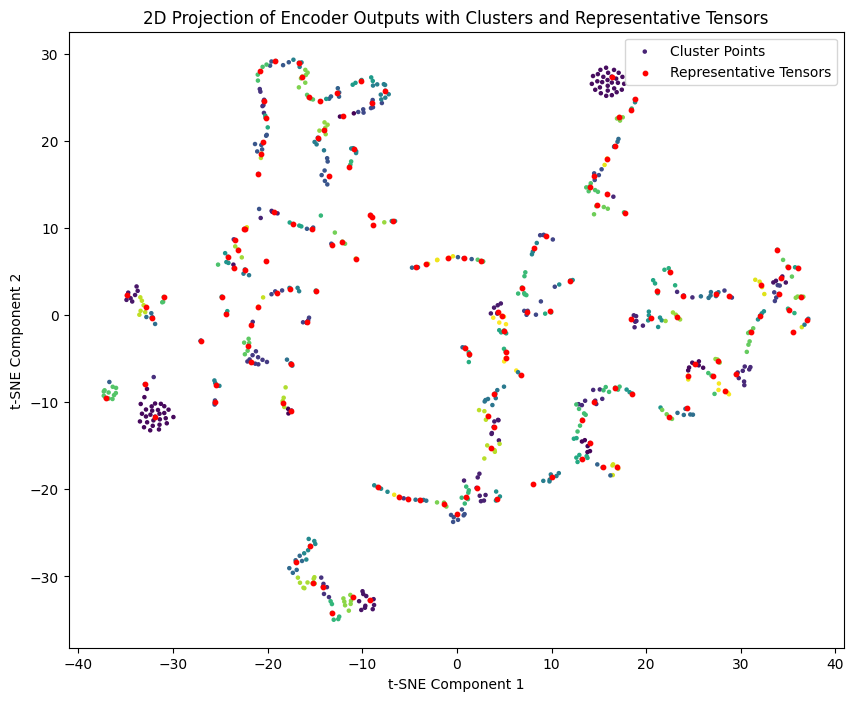

In [16]:
###PLOT PROJECTION
import torch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Assuming encoder_outs is your list of tensors
# Step 1: Convert list of tensors to a single tensor
encoder_outs_tensor = torch.cat(encoder_outs, dim=0)  # Shape: (samples, 128)

# Step 2: Apply k-means clustering
n_clusters = 150  # Set the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(encoder_outs_tensor.numpy())

# Step 3: Find the tensor closest to each cluster centroid
centroids = kmeans.cluster_centers_
closest_indices = []

for centroid in centroids:
    # Compute the distance between the centroid and all points
    distances = torch.norm(encoder_outs_tensor - torch.tensor(centroid), dim=1)
    # Find the index of the closest point
    closest_index = torch.argmin(distances).item()
    closest_indices.append(closest_index)

print("Indices of the most representative tensors:", closest_indices)

# Step 4: Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
encoder_outs_2d = tsne.fit_transform(encoder_outs_tensor.numpy())

# Step 5: Plot the clusters and the selected tensors
plt.figure(figsize=(10, 8))
plt.scatter(encoder_outs_2d[:, 0], encoder_outs_2d[:, 1], c=kmeans.labels_, cmap='viridis', s=5, label='Cluster Points')
plt.scatter(encoder_outs_2d[closest_indices, 0], encoder_outs_2d[closest_indices, 1], c='red', s=10, label='Representative Tensors')
plt.title('2D Projection of Encoder Outputs with Clusters and Representative Tensors')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

In [12]:
contrastive_dataset = ContrastiveBufferDataset(train_dataset, buffer_size=250, device='cuda:2')
#replay_dataset = StandardBufferDataset(train_dataset, buffer_size=300)
#temporal_dataset = TemporalBufferDataset(train_dataset, buffer_size=300)

** Using avgpool **
======> Encoder: output dim 2048 | 25.557M parameters
Executing step 1
encoder outs shapetorch.Size([1, 128])
Executing step 2
Clustering k= 250


In [13]:
load_config(cfg, '/home/pasti/PycharmProjects/Robot_CLOD/eclod/cfg/CREP250task2.yml')
train_dataset = build_dataset(cfg.data.train, "train")
contrastive_dataset.update_buffer(train_dataset, 2)
#replay_dataset.update_buffer2(train_dataset,2)
#temporal_dataset.update_buffer(train_dataset)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
['bag', 'bottle', 'cardboard box', 'chair', 'potted plant', 'traffic cone', 'trashcan', 'ball', 'broom', 'garden hose', 'bucket', 'bycicle', 'gardening tool']
Executing step 1
encoder outs shapetorch.Size([1, 128])
Executing step 2
Clustering k= 125


In [14]:
load_config(cfg, '/home/pasti/PycharmProjects/Robot_CLOD/eclod/cfg/CREP250task3.yml')
train_dataset = build_dataset(cfg.data.train, "train")
contrastive_dataset.update_buffer(train_dataset, 3)
#replay_dataset.update_buffer2(train_dataset, 5)
#temporal_dataset.smart_update_buffer(train_dataset,5)

load_config(cfg, '/home/pasti/PycharmProjects/Robot_CLOD/eclod/cfg/CREP250task4.yml')
train_dataset = build_dataset(cfg.data.train, "train")
contrastive_dataset.update_buffer(train_dataset, 4)
#replay_dataset.update_buffer2(train_dataset, 5)
#temporal_dataset.smart_update_buffer(train_dataset,5)

load_config(cfg, '/home/pasti/PycharmProjects/Robot_CLOD/eclod/cfg/CREP250task5.yml')
train_dataset = build_dataset(cfg.data.train, "train")
contrastive_dataset.update_buffer(train_dataset, 5)
#replay_dataset.update_buffer2(train_dataset, 5)
#temporal_dataset.smart_update_buffer(train_dataset,5)

load_config(cfg, '/home/pasti/PycharmProjects/Robot_CLOD/eclod/cfg/CREP250task6.yml')
train_dataset = build_dataset(cfg.data.train, "train")
contrastive_dataset.update_buffer(train_dataset, 6)
#replay_dataset.update_buffer2(train_dataset, 6)
#temporal_dataset.smart_update_buffer(train_dataset,6)

load_config(cfg, '/home/pasti/PycharmProjects/Robot_CLOD/eclod/cfg/CREP250task7.yml')
train_dataset = build_dataset(cfg.data.train, "train")
contrastive_dataset.update_buffer(train_dataset, 7)
#replay_dataset.update_buffer2(train_dataset, 7)
#temporal_dataset.smart_update_buffer(train_dataset,7)

load_config(cfg, '/home/pasti/PycharmProjects/Robot_CLOD/eclod/cfg/CREP250task8.yml')
train_dataset = build_dataset(cfg.data.train, "train")
contrastive_dataset.update_buffer(train_dataset, 8)
#replay_dataset.update_buffer2(train_dataset, 8)
#temporal_dataset.smart_update_buffer(train_dataset,8)

load_config(cfg, '/home/pasti/PycharmProjects/Robot_CLOD/eclod/cfg/CREP250task9.yml')
train_dataset = build_dataset(cfg.data.train, "train")
contrastive_dataset.update_buffer(train_dataset, 9)
#replay_dataset.update_buffer2(train_dataset, 9)
#temporal_dataset.smart_update_buffer(train_dataset,9)

load_config(cfg, '/home/pasti/PycharmProjects/Robot_CLOD/eclod/cfg/CREP250task10.yml')
train_dataset = build_dataset(cfg.data.train, "train")
contrastive_dataset.update_buffer(train_dataset, 10)
#replay_dataset.update_buffer2(train_dataset, 10)
#temporal_dataset.smart_update_buffer(train_dataset,10)

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
['bag', 'bottle', 'cardboard box', 'chair', 'potted plant', 'traffic cone', 'trashcan', 'ball', 'broom', 'garden hose', 'bucket', 'bycicle', 'gardening tool']
Executing step 1
encoder outs shapetorch.Size([1, 128])
Executing step 2
Clustering k= 84
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
['bag', 'bottle', 'cardboard box', 'chair', 'potted plant', 'traffic cone', 'trashcan', 'ball', 'broom', 'garden hose', 'bucket', 'bycicle', 'gardening tool']
Executing step 1
encoder outs shapetorch.Size([1, 128])
Executing step 2
Clustering k= 64
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
['bag', 'bottle', 'cardboard box', 'chair', 'potted plant', 'traffic cone', 'trashcan', 'ball', 'broom', 'garden hose', 'bucket', 'bycicle', 'gardening tool']
Executing step 1
encoder outs shapetorch.Size([1, 128])
Executing step 2
Clustering k= 50
load

d1_h: 25
d1_l: 25
d2_h: 25
d2_l: 25
d3_h: 25
d3_l: 25
d4_h: 25
d4_l: 25
d5_h: 25
d5_l: 25


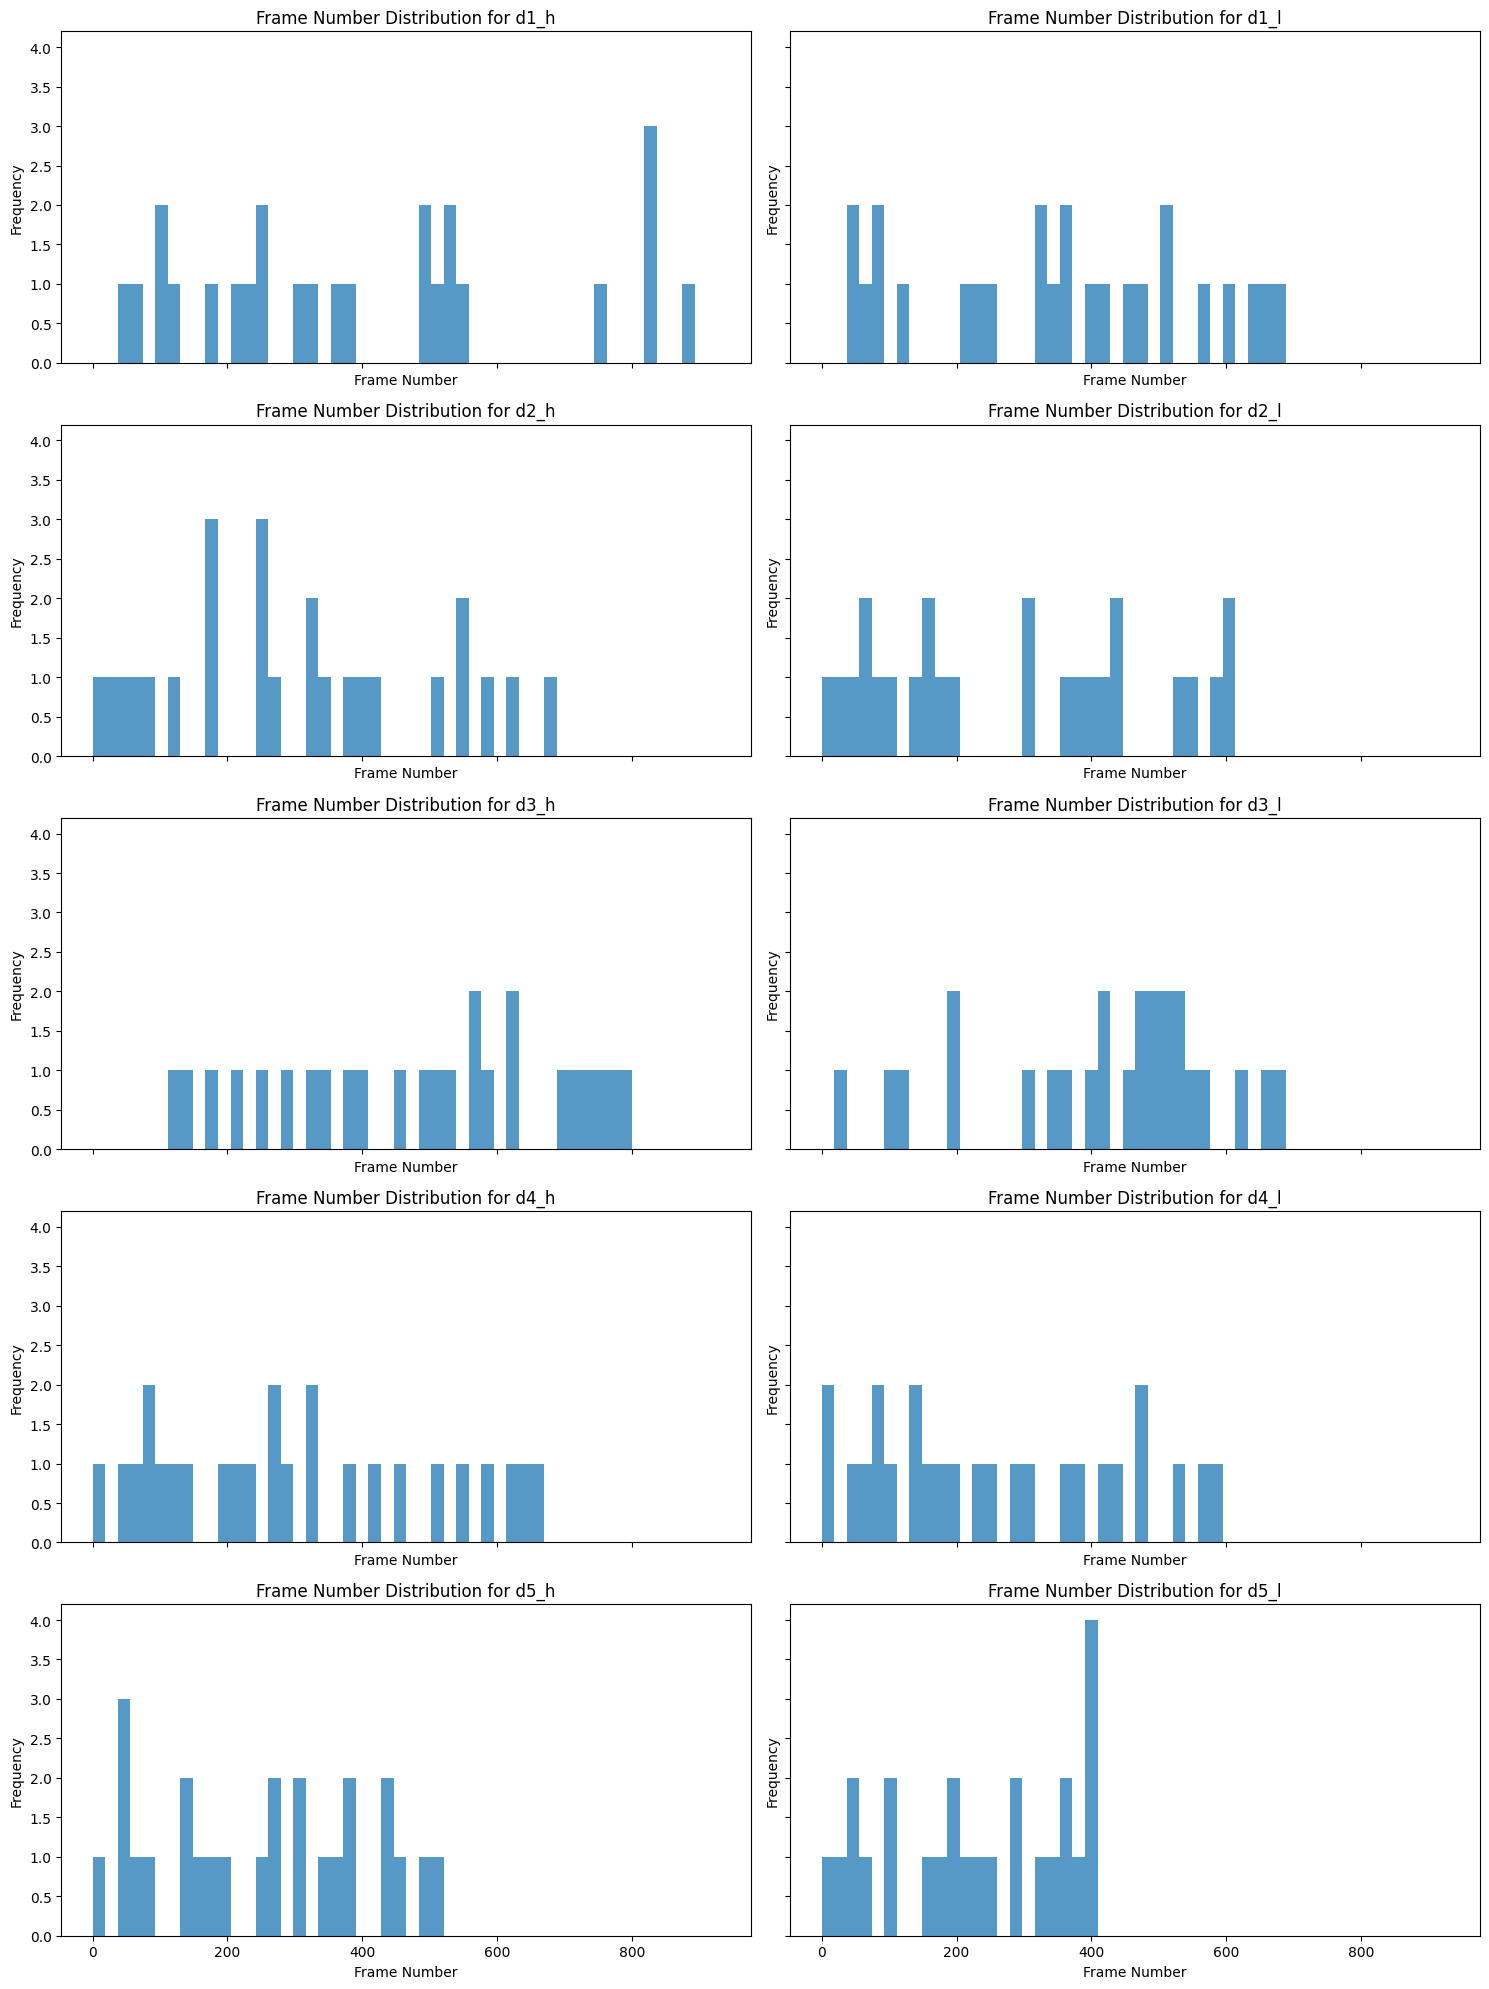

In [15]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict

# Assuming contrastive_dataset is already defined
frame_numbers_by_category = defaultdict(list)
category_counts = defaultdict(int)

for item in contrastive_dataset:
    filename = item['img_info']['file_name']
    match = re.search(r'(d\d+_[hl])_frame(\d+)', filename)
    if match:
        category = match.group(1)
        frame_number = int(match.group(2))
        frame_numbers_by_category[category].append(frame_number)
        category_counts[category] += 1

# Print the counts for each category
for category, count in category_counts.items():
    print(f"{category}: {count}")

# Create subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 20), sharex=True, sharey=True)
axes = axes.flatten()

# Plot histogram for each category
for idx, (category, frame_numbers) in enumerate(frame_numbers_by_category.items()):
    axes[idx].hist(frame_numbers, bins=50, range=(0, 930), alpha=0.75)
    axes[idx].set_title(f'Frame Number Distribution for {category}')
    axes[idx].set_xlabel('Frame Number')
    axes[idx].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

In [8]:
for item in contrastive_dataset:
    filename = item['img_info']['file_name']
    print(filename)

d1_h_frame274.png
d1_h_frame79.png
d1_h_frame517.png
d1_h_frame54.png
d1_h_frame308.png
d1_h_frame463.png
d1_h_frame377.png
d1_h_frame623.png
d1_h_frame878.png
d1_h_frame593.png
d1_h_frame834.png
d1_h_frame107.png
d1_h_frame254.png
d1_h_frame512.png
d1_h_frame482.png
d1_h_frame296.png
d1_h_frame661.png
d1_h_frame358.png
d1_h_frame283.png
d1_h_frame132.png
d1_h_frame852.png
d1_h_frame303.png
d1_h_frame787.png
d1_h_frame506.png
d1_h_frame662.png
d1_l_frame513.png
d1_l_frame377.png
d1_l_frame386.png
d1_l_frame381.png
d1_l_frame469.png
d1_l_frame239.png
d1_l_frame3.png
d1_l_frame276.png
d1_l_frame254.png
d1_l_frame574.png
d1_l_frame236.png
d1_l_frame676.png
d1_l_frame323.png
d1_l_frame64.png
d1_l_frame362.png
d1_l_frame374.png
d1_l_frame294.png
d1_l_frame158.png
d1_l_frame103.png
d1_l_frame6.png
d1_l_frame21.png
d1_l_frame354.png
d1_l_frame532.png
d1_l_frame444.png
d1_l_frame387.png
d2_h_frame251.png
d2_h_frame326.png
d2_h_frame138.png
d2_h_frame262.png
d2_h_frame389.png
d2_h_frame529.png


d1_h_frame278.png
d1_h_frame513.png
d1_h_frame279.png
d1_h_frame511.png
d1_h_frame377.png
d1_h_frame512.png
d1_h_frame514.png
d1_h_frame276.png
d1_h_frame293.png
d1_h_frame519.png
d1_h_frame267.png
d1_h_frame376.png
d1_h_frame517.png
d1_h_frame521.png
d1_h_frame277.png
d1_h_frame316.png
d1_h_frame518.png
d1_h_frame371.png
d1_h_frame509.png
d1_h_frame274.png
d1_h_frame516.png
d1_h_frame301.png
d1_h_frame292.png
d1_h_frame266.png
d1_h_frame107.png
d1_h_frame287.png
d1_h_frame286.png
d1_h_frame374.png
d1_h_frame273.png
d1_h_frame269.png
d1_h_frame522.png
d1_h_frame372.png
d1_h_frame304.png
d1_h_frame667.png
d1_h_frame668.png
d1_h_frame526.png
d1_h_frame317.png
d1_h_frame481.png
d1_h_frame524.png
d1_h_frame669.png
d1_h_frame654.png
d1_h_frame271.png
d1_h_frame272.png
d1_h_frame284.png
d1_h_frame836.png
d1_h_frame251.png
d1_h_frame527.png
d1_h_frame508.png
d1_h_frame523.png
d1_h_frame249.png
d1_h_frame652.png
d1_h_frame312.png
d1_h_frame314.png
d1_h_frame309.png
d1_h_frame653.png
d1_h_frame

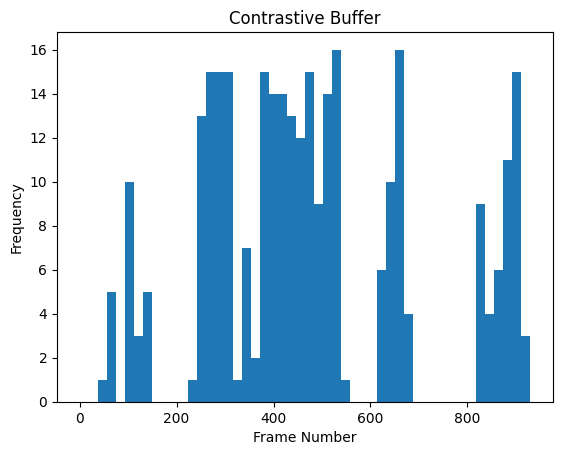

In [47]:
import re
import matplotlib.pyplot as plt

# Assuming buffer_dataset is already defined
frame_numbers = []

for item in contrastive_dataset:
    filename = item['img_info']['file_name']
    print(filename)
    match = re.search(r'frame(\d+)', filename)
    if match:
        frame_number = int(match.group(1))
        frame_numbers.append(frame_number)

# Plot histogram
plt.hist(frame_numbers, bins=50, range=(0, 930))
plt.xlabel('Frame Number')
plt.ylabel('Frequency')
plt.title('Contrastive Buffer')
plt.show()

In [ ]:
buffer_dataset.update_buffer(train_dataset, 2)

In [40]:
import sys

encoder_outs = []
total_memory = 0

for item in train_dataset:
    path = cfg.data.train.img_path + '/' + item['img_info']['file_name']
    img = PIL.Image.open(path)
    inp = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():  # Disable gradient calculation
        encoder_out = encoder(inp)[1].detach().cpu()  # Detach and move to CPU
    encoder_outs.append(encoder_out)
    total_memory += encoder_out.element_size() * encoder_out.nelement()

# Add the size of the list itself
total_memory += sys.getsizeof(encoder_outs)

print(f"Total memory used by encoder_outs: {total_memory / (1024 ** 2):.2f} MB")

Total memory used by encoder_outs: 0.36 MB


In [ ]:
print(encoder_outs[2].shape)
cosine_sim = F.cosine_similarity(encoder_outs[0], encoder_outs[1])
print("Cosine Similarity:", cosine_sim.item())

In [41]:
num_vectors = len(encoder_outs)
cosine_sim_matrix = torch.zeros((num_vectors, num_vectors))

for i in range(num_vectors):
    for j in range(num_vectors):
        cosine_sim_matrix[i, j] = F.cosine_similarity(encoder_outs[i], encoder_outs[j])

print("Cosine Similarity Matrix:")
print(cosine_sim_matrix[0,:])

Cosine Similarity Matrix:
tensor([1.0000, 0.8502, 0.8399, 0.8740, 0.8160, 0.7664, 0.6922, 0.9047, 0.8847,
        0.9491, 0.8592, 0.8553, 0.8775, 0.8354, 0.7364, 0.8280, 0.9382, 0.9481,
        0.9572, 0.9338, 0.8969, 0.9468, 0.9150, 0.9199, 0.8836, 0.8932, 0.8869,
        0.9659, 0.8431, 0.8361, 0.8552, 0.8228, 0.8683, 0.7910, 0.8656, 0.8094,
        0.9567, 0.7848, 0.9304, 0.9307, 0.9144, 0.9222, 0.9258, 0.9184, 0.9112,
        0.9213, 0.9363, 0.9333, 0.9409, 0.9321, 0.9293, 0.9414, 0.9383, 0.9549,
        0.9315, 0.9217, 0.9254, 0.8668, 0.9223, 0.9078, 0.8831, 0.8863, 0.9266,
        0.9012, 0.8709, 0.8767, 0.8928, 0.8877, 0.9071, 0.9097, 0.9166, 0.9399,
        0.8488, 0.8622, 0.8867, 0.9021, 0.8703, 0.8703, 0.9008, 0.8814, 0.9503,
        0.8964, 0.8851, 0.8819, 0.8748, 0.8894, 0.8714, 0.9056, 0.9061, 0.9973,
        0.8616, 0.8706, 0.8779, 0.8839, 0.8784, 0.8579, 0.8610, 0.8752, 0.9247,
        0.8593, 0.8432, 0.8227, 0.8444, 0.8670, 0.8872, 0.8833, 0.8894, 0.9396,
        0.8840

In [42]:
print(cosine_sim_matrix[:,0])

tensor([1.0000, 0.8502, 0.8399, 0.8740, 0.8160, 0.7664, 0.6922, 0.9047, 0.8847,
        0.9491, 0.8592, 0.8553, 0.8775, 0.8354, 0.7364, 0.8280, 0.9382, 0.9481,
        0.9572, 0.9338, 0.8969, 0.9468, 0.9150, 0.9199, 0.8836, 0.8932, 0.8869,
        0.9659, 0.8431, 0.8361, 0.8552, 0.8228, 0.8683, 0.7910, 0.8656, 0.8094,
        0.9567, 0.7848, 0.9304, 0.9307, 0.9144, 0.9222, 0.9258, 0.9184, 0.9112,
        0.9213, 0.9363, 0.9333, 0.9409, 0.9321, 0.9293, 0.9414, 0.9383, 0.9549,
        0.9315, 0.9217, 0.9254, 0.8668, 0.9223, 0.9078, 0.8831, 0.8863, 0.9266,
        0.9012, 0.8709, 0.8767, 0.8928, 0.8877, 0.9071, 0.9097, 0.9166, 0.9399,
        0.8488, 0.8622, 0.8867, 0.9021, 0.8703, 0.8703, 0.9008, 0.8814, 0.9503,
        0.8964, 0.8851, 0.8819, 0.8748, 0.8894, 0.8714, 0.9056, 0.9061, 0.9973,
        0.8616, 0.8706, 0.8779, 0.8839, 0.8784, 0.8579, 0.8610, 0.8752, 0.9247,
        0.8593, 0.8432, 0.8227, 0.8444, 0.8670, 0.8872, 0.8833, 0.8894, 0.9396,
        0.8840, 0.8751, 0.8688, 0.8699, 

In [ ]:
row_sums = torch.sum(cosine_sim_matrix, dim=1)

In [ ]:
smallest_values, smallest_indices = torch.topk(row_sums, 250, largest=False)

In [ ]:
print(smallest_values)

print(smallest_indices)

In [ ]:
load_config(cfg, '/home/pasti/PycharmProjects/Robot_CLOD/eclod/cfg/SIDtask2.yml')
train_dataset = build_dataset(cfg.data.train, "train")
for item in train_dataset:
    print(item['img_info']['file_name'])
    break

In [ ]:
buffer_dataset.update_buffer(train_dataset, 2)

In [ ]:
for item in buffer_dataset:
    print(item['img_info']['file_name'])

In [ ]:
load_config(cfg, '/home/pasti/PycharmProjects/Robot_CLOD/eclod/cfg/SIDtask3.yml')
train_dataset = build_dataset(cfg.data.train, "train")
for item in train_dataset:
    print(item['img_info']['file_name'])
    break

buffer_dataset.update_buffer(train_dataset, 2)
for item in buffer_dataset:
    print(item['img_info']['file_name'])